In [100]:
import os
import numpy as np
import tensorflow as tf

In [101]:
for dirpath, dirnames, filenames in os.walk("chest_xray"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray\test'.
There are 0 directories and 234 images in 'chest_xray\test\NORMAL'.
There are 0 directories and 390 images in 'chest_xray\test\PNEUMONIA'.
There are 2 directories and 0 images in 'chest_xray\train'.
There are 0 directories and 1341 images in 'chest_xray\train\NORMAL'.
There are 0 directories and 3875 images in 'chest_xray\train\PNEUMONIA'.
There are 2 directories and 0 images in 'chest_xray\val'.
There are 0 directories and 8 images in 'chest_xray\val\NORMAL'.
There are 0 directories and 8 images in 'chest_xray\val\PNEUMONIA'.


In [102]:
num_of_normal_images = len(os.listdir("chest_xray/train/NORMAL"))
num_of_normal_images

1341

In [103]:
num_of_normal_images = len(os.listdir("chest_xray/train/PNEUMONIA"))
num_of_normal_images

3875

In [104]:
num_of_normal_images = len(os.listdir("chest_xray/test/NORMAL"))
num_of_normal_images

234

In [105]:
num_of_normal_images = len(os.listdir("chest_xray/test/PNEUMONIA"))
num_of_normal_images

390

In [106]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15459272448262166791
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11973920080401279644
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [107]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

In [108]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = 'binary',
                                                                batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = 'binary',
                                                                batch_size = BATCH_SIZE)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [109]:
print(train_data)
print(test_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [110]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [111]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = 'data_augmentation')

In [112]:
import datetime

def tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    
    return tensorboard_callback

In [113]:
def checkpoint_callback(path):
    
    checkpoint = tf.keras.callback.ModelCheckpoint(filepath = path,
                                                  save_weights_only=True,
                                                  save_best_only = False,
                                                  save_freq = 'epoch',
                                                  verbose = 1)
    return checkpoint

In [114]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

for layer in base_model.layers[:-10]:
    layer.trainable = False

In [115]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 tf.math.truediv_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [116]:
INPUT_SHAPE = (224, 224, 3)

inputs = tf.keras.layers.Input(shape = INPUT_SHAPE, name = "input_layer")

x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(inputs, outputs)

model.compile(loss = "binary_crossentropy", 
             optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])

history = model.fit(train_data,
         epochs = 5,
         steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/5
163/163 [==============================] - 28s 140ms/step - loss: 0.2568 - accuracy: 0.9011 - val_loss: 0.4296 - val_accuracy: 0.7917
Epoch 2/5
163/163 [==============================] - 22s 133ms/step - loss: 0.1226 - accuracy: 0.9574 - val_loss: 0.4175 - val_accuracy: 0.8285
Epoch 3/5
163/163 [==============================] - 22s 133ms/step - loss: 0.0892 - accuracy: 0.9691 - val_loss: 0.4441 - val_accuracy: 0.8269
Epoch 4/5
163/163 [==============================] - 24s 142ms/step - loss: 0.0797 - accuracy: 0.9712 - val_loss: 0.5404 - val_accuracy: 0.8093
Epoch 5/5
163/163 [==============================] - 24s 143ms/step - loss: 0.0668 - accuracy: 0.9776 - val_loss: 0.5230 - val_accuracy: 0.8237


In [117]:
y_hat = model.predict(test_data)

20/20 [==============================] - 4s 105ms/step


In [118]:
y_hat

array([[9.98166025e-01],
       [4.39734697e-01],
       [9.92938221e-01],
       [9.97185647e-01],
       [7.11495459e-01],
       [9.90124404e-01],
       [9.97388780e-01],
       [9.87850726e-01],
       [7.86037922e-01],
       [9.91834164e-01],
       [9.97571170e-01],
       [2.29846492e-01],
       [9.99724686e-01],
       [4.49481755e-01],
       [7.30804026e-01],
       [9.96830761e-01],
       [2.54623026e-01],
       [9.99651432e-01],
       [9.97730792e-01],
       [9.86527503e-01],
       [5.30897677e-01],
       [6.24609292e-01],
       [4.11398947e-01],
       [9.98109460e-01],
       [9.02964234e-01],
       [9.98815656e-01],
       [9.97576773e-01],
       [9.99513268e-01],
       [7.73057580e-01],
       [9.89572942e-01],
       [2.76847810e-01],
       [9.97405112e-01],
       [9.49987829e-01],
       [1.65966198e-01],
       [5.46711199e-02],
       [9.99174893e-01],
       [3.36747140e-01],
       [9.55552459e-01],
       [9.96423662e-01],
       [9.99037147e-01],


In [119]:
len(y_hat)

624

In [120]:
import itertools
import matplotlib.pyplot as plt

In [121]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

  # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

  # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

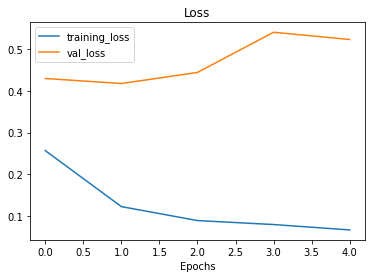

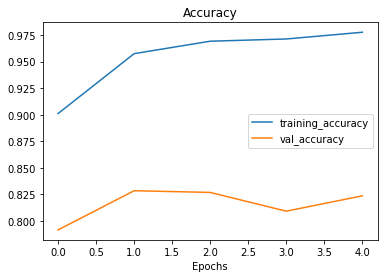

In [122]:
plot_loss_curves(history)